In [1]:
!pip3 install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
df = pd.read_csv('GPTNameTHEN.txt', sep=".", header=None, index_col=0)

In [3]:
df.columns = ["Name"]
df.head()

,Name
0,
1,สมชาย ใจดี (Somchai Jai Dee)
2,รุ่งทิวา สวยงาม (Rungtiwa Suayngam)
3,ภัทราพร รักชาติ (Patharaporn Rukchat)
4,อรวรรณ มีรักษ์ (Orawan Mee-rak)
5,ณัฐวรรณ สุขใจ (Nattawan Sukjai)


In [4]:
import regex as re
def en_th_sep(name = 'name'):
    name = name.split('(')
    name[1] = name[1].replace(')', '')
    name[0] = name[0].strip()
    if re.search(r'[ก-๙]', name[0]):
        return name[1], name[0]
    else:
        return name[0], name[1]

In [5]:
df['en'], df['th'] = zip(*df['Name'].map(en_th_sep))

In [6]:
df = df.drop(columns=['Name'])
df.head()

,en,th
0,,
1,Somchai Jai Dee,สมชาย ใจดี
2,Rungtiwa Suayngam,รุ่งทิวา สวยงาม
3,Patharaporn Rukchat,ภัทราพร รักชาติ
4,Orawan Mee-rak,อรวรรณ มีรักษ์
5,Nattawan Sukjai,ณัฐวรรณ สุขใจ


In [7]:
stock_df = pd.read_csv('stock_details_18_Jan_2023.csv')

In [8]:
stock_df

,ลำดับ,รายชื่อผู้ถือหุ้น,จำนวนหุ้น (หุ้น),% หุ้น,stock_index,customer_type,price,asset_holding
0,1.0,บริษัท พาหนะ อินเวสเตอร์ จำกัด,915404678.0,17.80,7UP,บริษัท,0.8,732323742.4
1,2.0,น.ส. ชมกมล พุ่มพันธุ์ม่วง,400000000.0,7.78,7UP,บุคคล,0.8,320000000.0
2,3.0,นาย รชต พุ่มพันธุ์ม่วง,301950000.0,5.87,7UP,บุคคล,0.8,241560000.0
3,4.0,พล.ต.ต. สมยศ พุ่มพันธุ์ม่วง,266375434.0,5.18,7UP,บุคคล,0.8,213100347.2
4,5.0,นาย เชาวรัตน์ เวศม์ภิญโญ,110986700.0,2.16,7UP,บุคคล,0.8,88789360.0
...,...,...,...,...,...,...,...,...
8818,7.0,นาย ศิรุวัฒน์ ชัชวาลย์,4750000.0,1.58,ZEN,บุคคล,16.8,79800000.0
8819,8.0,นาง สุภาเจษฐ วิวัฒนาเกษม,4319990.0,1.44,ZEN,บุคคล,16.8,72575832.0
8820,9.0,นาย ปริญญ์ จิราธิวัฒน์,4045700.0,1.35,ZEN,บุคคล,16.8,67967760.0
8821,10.0,น.ส. สุจันท์ภา พลางกูร,3780000.0,1.26,ZEN,บุคคล,16.8,63504000.0


In [9]:
name_list = stock_df[stock_df['customer_type'] == 'บุคคล']['รายชื่อผู้ถือหุ้น'].tolist()

In [10]:
name_list

['น.ส. ชมกมล พุ่มพันธุ์ม่วง',
 'นาย รชต พุ่มพันธุ์ม่วง',
 'พล.ต.ต. สมยศ พุ่มพันธุ์ม่วง',
 'นาย เชาวรัตน์ เวศม์ภิญโญ',
 'นาย ธราธิป ธาราธรรมรัตน์',
 'นาย พิชิต พรสิริภร',
 'นาย เฉลิมชัย มหากิจศิริ',
 'น.ส. ลลิตา สอนบุญลา',
 'Sustainable Battery Solutions, Inc.',
 'SUSTAINABLE BATTERY SOLUTIONS, INC.',
 'นาย สมชาติ พงคพนาไกร',
 'นาย เจน วิภวพาณิชย์',
 'MRS. FANG XIE',
 'นาย จำนงค์ วัฒนเกส',
 'น.ส. จุฑารัตน์ จันทรัศมี',
 'นาย สมบัติ ลีสวัสดิ์ตระกูล',
 'นาย แสงรุ้ง นิติภาวะชน',
 'นาย ปรีดา วงศ์สถิตย์พร',
 'น.ส. ธนิกา ตั้งพูนผลวิวัฒน์',
 'น.ส. นิสาภ์ รุ่งรัตนาอุบล',
 'น.ส. บุญศรี ปัญญาเปี่ยมศักดิ์',
 'น.ส. อัมพร นิติภาวะชน',
 'นาย สันต์ อมรเลิศวิมาน',
 'นาย วิเชียร ศรีมุนินทร์นิมิต',
 'น.ส. ศิวพร นิติภาวะชน',
 'นาย ยศวีย์ วัฒนธีระกิจจา',
 'นาย สันติ มณีวงศ์',
 'นาย ธวัชชัย จิรวัฒนอังคณา',
 'นาง ประไพ วงศ์มาเกษ',
 'นาย พูลสวัสดิ์ ศรีภัทรานุสรณ์',
 'นาย ภาณุภณ วรพาณี',
 'นาย เกรียงศักดิ์ วงศ์โอสถพานิช',
 'นางสาว จิระวรรณ ไชยพงศ์ผาติ',
 'นางสาว ภริษา ฉายาวสันต์',
 'นาย วสันต์ จาวลา',
 'DB FFT 

In [11]:
from trdg.utils import mask_to_bboxes, draw_bounding_boxes

In [16]:
from trdg.generators import (
    GeneratorFromStrings )

# The generators use the same arguments as the CLI, only as parameters
generator = GeneratorFromStrings(
    # df['th'].tolist() + df['en'].tolist(),
    # ['พ่อ', 'ลุง', 'ฉัน', 'ญู', 'ฎู', 'ฏู', 'ฐู', 'ฦา', 'นั่น', 'น่ัน', 'พี่', 'พ่ี', 'นู้น', 'นั้น', 'น้ำ', 'นำ้', 'ปำ', 'ฝ่ำ', 'ดี้้'],
    name_list,
    blur=0,
    random_blur=False,
    language='th',
    # count=len(df['th'].tolist())*2,
    count=len(name_list),
    # count=20,
    fonts=[
        'trdg/fonts/th/upcdb.ttf', 
        # 'trdg/fonts/th/upcdbi.ttf',
        # 'trdg/fonts/th/upcdi.ttf', 
        'trdg/fonts/th/upcdl.ttf',
    ],
    size=64,
    background_type=3,
    image_dir='thai_id_bg/',
    margins = (5,5,5,5),
    output_mask=True,
    output_bboxes=3,
)   

In [17]:
from trdg.computer_text_generator import TH_TONE_MARKS, TH_UNDER_VOWELS, TH_UPPER_VOWELS, TH_SARA_AM
from trdg.computer_text_generator import th_grouping
def th_tone_vowel_bbox_sep(lbl, bboxes):
    splitted_text = th_grouping(lbl)
    # print(splitted_text)
    # print(bboxes)
    new_bboxes = []
    for i, s in enumerate(splitted_text):
        bbox = bboxes[i]
        len_s = len(s)
        if len_s > 1:
            if len_s == 2 and s[0] not in ['ญ', 'ฐ']:
                s2 = "{0:#x}".format(ord(s[1]))
                if s2 in TH_TONE_MARKS: # tone only
                    h = bbox[3] - bbox[1]
                    tone_bbox = (bbox[0], bbox[1], bbox[2], bbox[1]+round(h*0.3))
                    new_bboxes.append(tone_bbox) 
                    alpha_bbox = (bbox[0], bbox[1] + round(h*0.3), bbox[2], bbox[3])
                    new_bboxes.append(alpha_bbox)
                elif s2 in TH_UPPER_VOWELS: # upper_vowel only
                    h = bbox[3] - bbox[1]
                    upper_vowel_bbox = (bbox[0], bbox[1], bbox[2], bbox[1]+round(h*0.3))
                    new_bboxes.append(upper_vowel_bbox)
                    alpha_bbox = (bbox[0], bbox[1] + round(h*0.3), bbox[2], bbox[3])
                    new_bboxes.append(alpha_bbox)
                elif s2 in TH_UNDER_VOWELS: # under_vowel only
                    h = bbox[3] - bbox[1]
                    alpha_bbox = (bbox[0], bbox[1], bbox[2], bbox[1]+round(h*0.7))
                    new_bboxes.append(alpha_bbox)
                    under_vowel_bbox = (bbox[0], bbox[1]+round(h*0.7), bbox[2], bbox[3])
                    new_bboxes.append(under_vowel_bbox)
                elif s2 in TH_SARA_AM: # sara_am only
                    if s[0] in ['ป', 'ฝ']:
                        w = bbox[2] - bbox[0]
                        alpha_bbox = (bbox[0], bbox[1], bbox[0]+round(w*0.6), bbox[3])
                        new_bboxes.append(alpha_bbox)
                        sara_am_bbox = (bbox[0]+round(w*0.2), bbox[1], bbox[2], bbox[3])
                        new_bboxes.append(sara_am_bbox)
                    else :
                        w = bbox[2] - bbox[0]
                        alpha_bbox = (bbox[0], bbox[1], bbox[0]+round(w*0.6), bbox[3])
                        new_bboxes.append(alpha_bbox)
                        sara_am_bbox = (bbox[0]+round(w*0.4), bbox[1], bbox[2], bbox[3])
                        new_bboxes.append(sara_am_bbox)
                else :
                    new_bboxes.append(bbox)
            elif len_s == 3 and s[0] not in ['ญ', 'ฐ']:
                s2 = "{0:#x}".format(ord(s[1]))
                s3 = "{0:#x}".format(ord(s[2]))
                if s2 in TH_UPPER_VOWELS and s3 in TH_TONE_MARKS: # upper_vowel + tone
                    h = bbox[3] - bbox[1]
                    tone_bbox = (bbox[0], bbox[1], bbox[2], bbox[1]+round(h*0.23))
                    new_bboxes.append(tone_bbox)
                    upper_vowel_bbox = (bbox[0], bbox[1]+round(h*0.23), bbox[2], bbox[1]+round(h*0.5))
                    new_bboxes.append(upper_vowel_bbox)
                    alpha_bbox = (bbox[0], bbox[1]+round(h*0.5), bbox[2], bbox[3])
                    new_bboxes.append(alpha_bbox)
                
                elif s2 in TH_UNDER_VOWELS and s3 in TH_TONE_MARKS: # under_vowel + tone    
                    h = bbox[3] - bbox[1]
                    tone_bbox = (bbox[0], bbox[1], bbox[2], bbox[1]+round(h*0.23))
                    new_bboxes.append(tone_bbox)
                    alpha_bbox = (bbox[0], bbox[1]+round(h*0.23), bbox[2], bbox[1]+round(h*0.72))
                    new_bboxes.append(alpha_bbox)
                    under_vowel_bbox = (bbox[0], bbox[1]+round(h*0.72), bbox[2], bbox[3])
                    new_bboxes.append(under_vowel_bbox)
                elif s2 in TH_TONE_MARKS and s3 in TH_SARA_AM: # sara_am + tone
                    h = bbox[3] - bbox[1]
                    tone_bbox = (bbox[0], bbox[1], bbox[2], bbox[1]+round(h*0.25))
                    new_bboxes.append(tone_bbox)
                    sara_am_bbox = (bbox[0], bbox[1]+round(h*0.3), bbox[2], bbox[3])
                    if s[0] in ['ป', 'ฝ']:
                        w = bbox[2] - bbox[0]
                        alpha_bbox = (sara_am_bbox[0], sara_am_bbox[1], sara_am_bbox[0]+round(w*0.6), sara_am_bbox[3])
                        new_bboxes.append(alpha_bbox)
                        sara_am_bbox = (sara_am_bbox[0]+round(w*0.2), sara_am_bbox[1], sara_am_bbox[2], sara_am_bbox[3])
                        new_bboxes.append(sara_am_bbox)
                    else :
                        w = bbox[2] - bbox[0]
                        alpha_bbox = (sara_am_bbox[0], sara_am_bbox[1], sara_am_bbox[0]+round(w*0.6), sara_am_bbox[3])
                        new_bboxes.append(alpha_bbox)
                        sara_am_bbox = (sara_am_bbox[0]+round(w*0.4), sara_am_bbox[1], sara_am_bbox[2], sara_am_bbox[3])
                        new_bboxes.append(sara_am_bbox)
                else :
                    new_bboxes.append(bbox)
            elif s[0] in ['ญ', 'ฐ']:
                h = bbox[3] - bbox[1]
                alpha_bbox = (bbox[0], bbox[1], bbox[2], bbox[3])
                new_bboxes.append(alpha_bbox)
                under_vowel_bbox = (bbox[0], bbox[1]+round(h*0.7), bbox[2], bbox[3])
                new_bboxes.append(under_vowel_bbox)
        else :
            new_bboxes.append(bbox)
    # print(new_bboxes)
    return splitted_text, new_bboxes

In [14]:
from PIL import ImageDraw
for (img, mask), lbl in generator:
    bboxes = mask_to_bboxes(mask)
    lbl, bboxes = th_tone_vowel_bbox_sep(lbl, bboxes)
    lbl = ''.join(lbl)
    # print(lbl)
    # print(f'{len(bboxes)} bboxes : {len(lbl)} chars')
    if len(bboxes) != len(lbl) :
        print(lbl)
        d = ImageDraw.Draw(img)
        for bbox in bboxes:
            d.rectangle(bbox, outline="green")
        display(img)

In [15]:
import time
import os
from tqdm import tqdm
from pyblp import save_pickle

def current_milli_time():
    return round(time.time() * 1000)

project_dir = 'ThaiID_from_stockdf'
full_path =os.path.dirname(os.path.realpath("__file__"))
project_dir = os.path.join(full_path,project_dir)
dirname = 'train'
dir_path = os.path.join(project_dir,dirname)
os.makedirs(dir_path,exist_ok=True)
texts = []
save_dir_img =os.path.join(dir_path,'imgs')
# rmtree(save_dir_img,ignore_errors=True)
os.makedirs(save_dir_img,exist_ok=True)

save_dir_bbox =os.path.join(dir_path,'bbox')
# rmtree(save_dir_bbox,ignore_errors=True)
os.makedirs(save_dir_bbox,exist_ok=True)

save_dir_mask =os.path.join(dir_path,'mask')
# rmtree(save_dir_mask,ignore_errors=True)
os.makedirs(save_dir_mask,exist_ok=True)

for i in tqdm(generator):
    if i[0]:
        (img, mask), lbl = i
        try:
            # lbl = lbl.replace('—','')
            # display(img)
            bboxes = mask_to_bboxes(mask)
            lbl, bboxes = th_tone_vowel_bbox_sep(lbl, bboxes)
            lbl = ''.join(lbl)
            timestamp = current_milli_time()
            filename = f'{timestamp}.jpg'
            filename_mask = f'{timestamp}.png'
            bbox_filename = f'{timestamp}.pkl'
            image_path = os.path.join(save_dir_img,filename)
            bbox_path = os.path.join(save_dir_bbox,bbox_filename)

            mask_path = os.path.join(save_dir_mask,filename_mask)
            save_pickle(bboxes, bbox_path)
            # txt_imagepath =os.path.join('test',filename)

            # resized = img.resize((340,70))
            img.save(image_path)
            mask.save(mask_path)
            texts.append(f'{filename} {lbl}\n')
        # print(lbl)
        except Exception as e:
            print(e)
            print(lbl)
with open(os.path.join(dir_path,'gt.txt'),'a') as f:
    f.writelines(''.join(texts))

6532it [08:01, 13.56it/s]


# Test with a single image

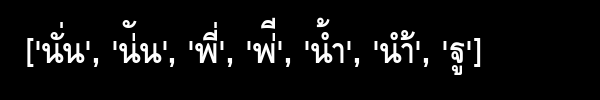

In [50]:
from PIL import Image, ImageFont, ImageDraw

text_string = str(['นั่น', 'น่ัน', 'พี่', 'พ่ี', 'น้ำ', 'นำ้'])

img = Image.new('RGB', (600, 100))
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('trdg/fonts/th/upcdb.ttf', 50, layout_engine=ImageFont.Layout.RAQM)

draw.text((25,40), text_string, fill='white', font=font)

display(img)